

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/healthcare_jsl/CLINICAL_NER.ipynb)




# **How to use Licensed NER models in Spark NLP**

### Spark NLP documentation and instructions:
https://nlp.johnsnowlabs.com/docs/en/quickstart

### You can find details about Spark NLP annotators here:
https://nlp.johnsnowlabs.com/docs/en/annotators

### You can find details about Spark NLP models here:
https://nlp.johnsnowlabs.com/models


To run this yourself, you will need to upload your license keys to the notebook. Just Run The Cell Below in order to do that. Also You can open the file explorer on the left side of the screen and upload `license_keys.json` to the folder that opens.
Otherwise, you can look at the example outputs at the bottom of the notebook.



## 1. Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print("Please Upload your John Snow Labs License using the button below")
license_keys = files.upload()

In [ ]:
from johnsnowlabs import *

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
# Make sure to restart your notebook afterwards for changes to take effect

jsl.install()

## 2. Start Session

In [ ]:
from johnsnowlabs import *
# Automatically load license data and start a session with all jars user has access to
spark = jsl.start()

## 2. Usage Guidelines

1. **Selecting the correct NER Model**

> a. To select from all the NER models available in Spark NLP please go to https://nlp.johnsnowlabs.com/models?tag=ner

> b. Read through the model descriptions to select desired model

---
2. **Selecting correct embeddings for the chosen NER model**
> a. Generally, embeddings are mentioned in the model information section (dependencies row), or in the description.

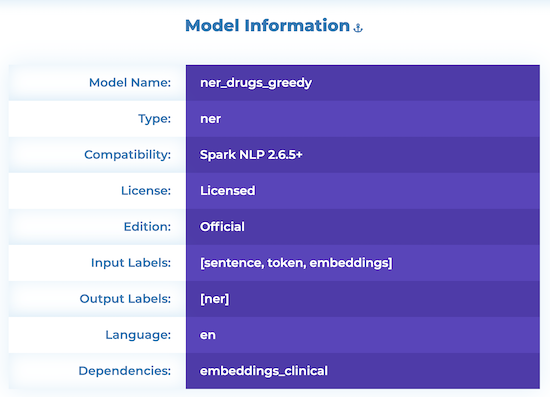

> b. If the information is missing, a general rule is: If the name of the model contains "**biobert**" (e.g: *ner_anatomy_biobert*) then the model is trained using "**biobert_pubmed_base_cased**" embeddings. Otherwise, "**embeddings_clinical**" was used to train that model.


> c. Using correct embeddings

>> To use *embeddings_clinical* :

>>> word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

>> To use *Bert* Embeddings:

>>> embeddings = BertEmbeddings.pretrained('biobert_pubmed_base_cased')\
    .setInputCols(["document", 'token'])\
    .setOutputCol("word_embeddings")

    
> d. You can find list of all embeddings here: https://nlp.johnsnowlabs.com/models?tag=embeddings


### Create the pipeline

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol('text')\
    .setOutputCol('document')

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = nlp.Tokenizer()\
    .setInputCols(['sentence']) \
    .setOutputCol('token')

word_embeddings = nlp.WordEmbeddingsModel.pretrained('embeddings_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('embeddings')

# change the model according to requirement
clinical_ner = medical.NerModel.pretrained('ner_drugs_greedy', "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
    .setInputCols(['sentence', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(
    stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter
        ])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_drugs_greedy download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


## 3. Create example inputs

In [ ]:
# Enter examples as strings in this array
input_list = [
    """The patient is a 30-year-old female with a long history of insulin dependent diabetes, type 2; coronary artery disease; chronic renal insufficiency; peripheral vascular disease, also secondary to diabetes; who was originally admitted to an outside hospital for what appeared to be acute paraplegia, lower extremities. She did receive a course of Bactrim for 14 days for UTI. Evidently, at some point in time, the patient was noted to develop a pressure-type wound on the sole of her left foot and left great toe. She was also noted to have a large sacral wound; this is in a similar location with her previous laminectomy, and this continues to receive daily care. The patient was transferred secondary to inability to participate in full physical and occupational therapy and continue medical management of her diabetes, the sacral decubitus, left foot pressure wound, and associated complications of diabetes. She is given Fragmin 5000 units subcutaneously daily, Xenaderm to wounds topically b.i.d., Lantus 40 units subcutaneously at bedtime, OxyContin 30 mg p.o. q.12 h., folic acid 1 mg daily, levothyroxine 0.1 mg p.o. daily, Prevacid 30 mg daily, Avandia 4 mg daily, Norvasc 10 mg daily, Lexapro 20 mg daily, aspirin 81 mg daily, Senna 2 tablets p.o. q.a.m., Neurontin 400 mg p.o. t.i.d., Percocet 5/325 mg 2 tablets q.4 h. p.r.n., magnesium citrate 1 bottle p.o. p.r.n., sliding scale coverage insulin, Wellbutrin 100 mg p.o. daily, and Bactrim DS b.i.d."""
    ]

## 4. Use the pipeline to create outputs

In [ ]:
import pandas as pd
from pyspark.sql.types import StringType, IntegerType

df = spark.createDataFrame(input_list, StringType()).toDF('text')

df.show(truncate = 100)

In [ ]:
result = nlp_pipeline.fit(df).transform(df)

## 5. Visualize results

Visualize using Spark NLP Display

In [ ]:
from sparknlp_display import NerVisualizer

NerVisualizer().display(result = result.collect()[0], label_col='ner_chunk', document_col='document')

Visualize outputs as data frame

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
    .select(F.expr("cols['0']").alias("chunk"), 
            F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)


+---------------------------------+---------+
|chunk                            |ner_label|
+---------------------------------+---------+
|insulin                          |DRUG     |
|Bactrim                          |DRUG     |
|Fragmin 5000 units subcutaneously|DRUG     |
|Lantus 40 units subcutaneously   |DRUG     |
|OxyContin 30 mg p.o              |DRUG     |
|folic acid 1 mg                  |DRUG     |
|levothyroxine 0.1 mg p.o         |DRUG     |
|Prevacid 30 mg                   |DRUG     |
|Avandia 4 mg                     |DRUG     |
|Norvasc 10 mg                    |DRUG     |
|Lexapro 20 mg                    |DRUG     |
|aspirin 81 mg                    |DRUG     |
|Senna 2 tablets p.o              |DRUG     |
|Neurontin 400 mg p.o             |DRUG     |
|magnesium citrate 1 bottle p.o   |DRUG     |
|insulin                          |DRUG     |
|Wellbutrin 100 mg p.o            |DRUG     |
|Bactrim DS                       |DRUG     |
+---------------------------------